# [실습02] MLP-학습
201910805 휴먼지능정보공학과 백서희

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 1. MNIST train, test dataset 가져오기

In [2]:
# "": 현재 폴더에 MNIST 있음
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# 2. 대략적인 데이터 형태

mnist_train 길이 60000
mnist_test 길이 10000
image data 형태: torch.Size([1, 28, 28])
label: 5


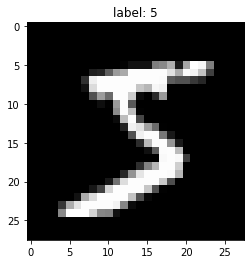

In [3]:
print("mnist_train 길이",len(mnist_train))
print("mnist_test 길이",len(mnist_test))

#데이터 하나 형태
image, label = mnist_train.__getitem__(0)
print("image data 형태:", image.size())
print("label:", label)

#그리기
img=image.numpy()
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

# 3. 데이터 로드 함수 

In [4]:
#hyper parameters
batch_size=1024
learning_rate=0.01
num_epoch=400

In [5]:
#mnist_train을 트레인 시키고, batch_size 만큼 나눌 떄 나머지는 버려라
train_loader=torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

데이터 로드 함수 이해하기

[0]
한 번에 로드되는 데이터 크기: 1024


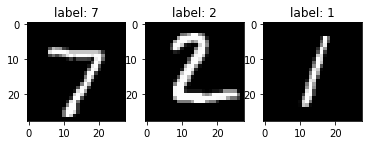

[1]
한 번에 로드되는 데이터 크기: 1024


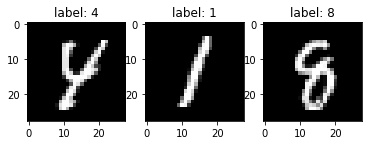

[2]
한 번에 로드되는 데이터 크기: 1024


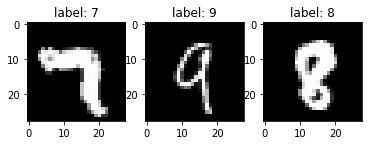

[3]
한 번에 로드되는 데이터 크기: 1024


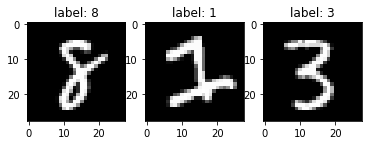

[4]
한 번에 로드되는 데이터 크기: 1024


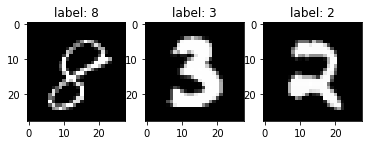

[5]
한 번에 로드되는 데이터 크기: 1024


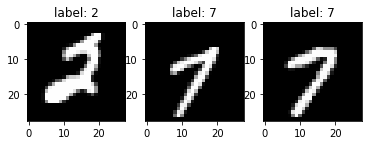

In [6]:
n=3 #샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader): #batch_size 만큼
    if i>5:
        break
    
    print("[%d]" %i)
    print("한 번에 로드되는 데이터 크기:",len(imgs))
    
    #그리기
    for j in range(n):
        img=imgs[j].numpy() # image 타입을 numpy로 변환 (1,28,28)
        img=img.reshape((img.shape[1],img.shape[2])) #(1,28,28) -> (28,28)
        #print img.shape
        
        plt.subplot(1,n,j+1) #(1,3) 형태 플랏의 j 번째 자리에 그리겠다.
        plt.imshow(img, cmap='gray')
        plt.title("label: %d" %labels[j])
    plt.show()

# 4. 모델 선언

In [7]:
#모델 선언
# * 퍼셉트론(2 hidden layer)
model=nn.Sequential(
    nn.Linear(28*28,256),
    nn.Sigmoid(), #nn.ReLU(), #nn.Sigmoid  91.89%
    nn.Linear(256,128),
    nn.Linear(128,10),
)

#파라미터 보기
#print(list(model.parameters())) #초기 파라미터 출력

In [8]:
#model=model.cuba()

In [9]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): #batch_size 만큼
        img=imgs # x
        label=Variable(labels) # y
        # label=Variable(labels).cuba()
        #.cuba() : GPU에 로드되기 위함. 만약 CPU로 설정되어 있다면 에러 남
        
        #(batch_size, 1, 28, 28) -> (batch_size, 28, 28)
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        #(batch_size, 28,28) -> (batch_size, 28*28)
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        img=Variable(img, requires_grad=False)
        #img=Variable(img, requires_grad=False).cuba()
        
        output=imodel(img) #forward.prop
        _, output_index=torch.max(output,1)
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
        
    print("Accuracy of Test Data: {}" .format(100*correct/total))

In [10]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 9.765625


# 5. loss, optimizer

In [11]:
loss_func=nn.CrossEntropyLoss() #logit(# of classes), target(1)
optimizer=optim.SGD(model.parameters(), lr=learning_rate)

# 6. 학습

In [12]:
for i in range(num_epoch):
    for j, [imgs, labels] in enumerate(train_loader): #batch_size 만큼
        img=imgs # (batch_size, 1, 28, 28) 
        label=Variable(labels) # (batch_size)
        # label=Variable(labels).cuba() # (batch_size)
        
        #(batch_size, 1, 28, 28) -> (batch_size, 28, 28)
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        #(batch_size, 28,28) -> (batch_size, 28*28)
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        img=Variable(img, requires_grad=True)
        #img=Variable(img, requires_grad=True).cuba()
        
        optimizer.zero_grad()
        output=model(img) #forward.prop
        loss=loss_func(output, label) #logit(# of classes), target(1)

        loss.backward() #back prop
        optimizer.step() #weight 조정
        
    if i%50==0:
        print("%d" %i)
        ComputeAccr(test_loader, model)
        print(loss)

0
Accuracy of Test Data: 11.295573234558105
tensor(2.2993, grad_fn=<NllLossBackward>)
50
Accuracy of Test Data: 81.29340362548828
tensor(0.6962, grad_fn=<NllLossBackward>)
100
Accuracy of Test Data: 88.35720825195312
tensor(0.4357, grad_fn=<NllLossBackward>)
150
Accuracy of Test Data: 89.99565887451172
tensor(0.3596, grad_fn=<NllLossBackward>)
200
Accuracy of Test Data: 90.77690887451172
tensor(0.3071, grad_fn=<NllLossBackward>)
250
Accuracy of Test Data: 91.14583587646484
tensor(0.3160, grad_fn=<NllLossBackward>)
300
Accuracy of Test Data: 91.56900787353516
tensor(0.3216, grad_fn=<NllLossBackward>)
350
Accuracy of Test Data: 91.86197662353516
tensor(0.3129, grad_fn=<NllLossBackward>)


# 7. 테스트

In [13]:
# ComputeAccr(test_loader, model) #96. %(ReLU), 92.48%(ReLU X)

# 8. 학습된 파라미터 저장

In [15]:
netname='./mlp.weight.pkl'
torch.save(model, netname,)

#model=torch.load(netname)